In [4]:
import pandas as pd
import numpy as np
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Dataloader

In [3]:
data = np.genfromtxt("./oneD_power.csv", delimiter=",", skip_header=1)

X = data[:, :-1]
# X = data[:, :-1]
y = data[:, -1]


scaler = StandardScaler()
scaler2 = StandardScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler2.fit_transform(y.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


X_reshape = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)


# nn model

In [7]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu'), # relu
    Dense(512, activation='relu'), # relu
    Dense(1)
])

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    # Conv1D(filters=128, kernel_size=2, activation='relu'),
    # MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1)
])


# mlp_model = Sequential([
#     Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
#     MaxPooling1D(pool_size=2),
#     Flatten(),
#     Dense(50, activation='relu'),
#     Dropout(0.5),
#     Dense(1)
# ])


#  model info
# mlp_model.compile(optimizer='adam', loss='mean_squared_error')
# cnn_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 6, 64)             16896     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_22 (Dense)            (None, 50)                3250      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 51        
                                                                 
Total params: 53,221
Trainable params: 53,221
Non-trainable params: 0
_________________________________________________________________


In [8]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

result = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[tensorboard_callback])

Epoch 1/50
5000/5000 [==============================] - 150s 29ms/step - loss: 0.5707 - val_loss: 0.4173
Epoch 2/50
4278/5000 [========================>.....] - ETA: 15s - loss: 0.3949

In [9]:
# evaluation
y_pred = lstm_model.predict(X_test)
# predicted_power = mlp_model.predict(X_reshape)

# inverse scaler
y_test_original = scaler2.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler2.inverse_transform(y_pred).flatten()

# evaluation calculation
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


1563/1563 [==============================] - 10s 7ms/step
Mean Absolute Error: 0.003953590834004811
Mean Squared Error: 5.796068302320115e-05
R-squared: 0.016532022132527024


In [10]:
predicted_power = lstm_model.predict(X_reshape)

# inverse scaler
pre_ori = scaler2.inverse_transform(predicted_power).flatten()

7813/7813 [==============================] - 29s 4ms/step


In [12]:
import matplotlib.pyplot as plt

# Training history visualization
plt.plot(cnn_model.history['loss'], label='train')
plt.plot(cnn_model.history['val_loss'], label='validation')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

TypeError: 'History' object is not subscriptable

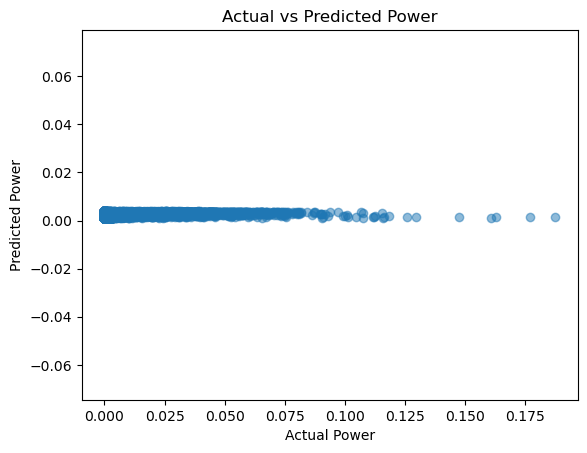

In [13]:
import matplotlib.pyplot as plt

# Prediction result visualization
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.xlabel('Actual Power')
plt.ylabel('Predicted Power')
plt.title('Actual vs Predicted Power')
plt.axis('equal')
plt.show()

### CSV import

In [47]:
import pandas as pd
results = pd.DataFrame({
    'Actual Power': y,
    'Predicted Power': pre_ori
})
results.to_csv('./Result/mlp_model.csv', index=False)

# MLP model

In [6]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, alpha=0.001,
                   solver='adam', random_state=42, learning_rate_init=0.001) # adam


mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(mse)
predicted_power = mlp.predict(X)


2.6399088039722796e-05


In [7]:
y_pred = mlp.predict(X_test_scaled)

In [8]:
mse = mean_squared_error(y_test, y_pred)
print(mse)

2.6399088039722796e-05


# RF_model

In [40]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train_scaled, y_train)

rf_accuracy = rf_model.score(X_test_scaled, y_test)
print(f"Random Forest accuracy: {rf_accuracy:.2f}")


Random Forest accuracy: 0.80


# LASSO model

# Evaluation

In [74]:
predicted_power = model.predict(X)

7813/7813 [==============================] - 26s 3ms/step


In [50]:
predicted_power = rf_model.predict(X)

In [122]:
predicted_power = mlp.predict(X)

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

class MLP_5(nn.Module):
    def __init__(self):
        super(MLP_5, self).__init__()
        self.fc1 = nn.Linear(5, 4)
        self.fc2 = nn.Linear(4, 3)
        self.fc3 = nn.Linear(3, 2)
        self.fc4 = nn.Linear(2, 1)
        self.activate = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        # x = self.nn.Sigmoid(x)
        x = self.activate(x)
        return x


In [2]:
(X[:,2])

NameError: name 'X' is not defined

# Visualization

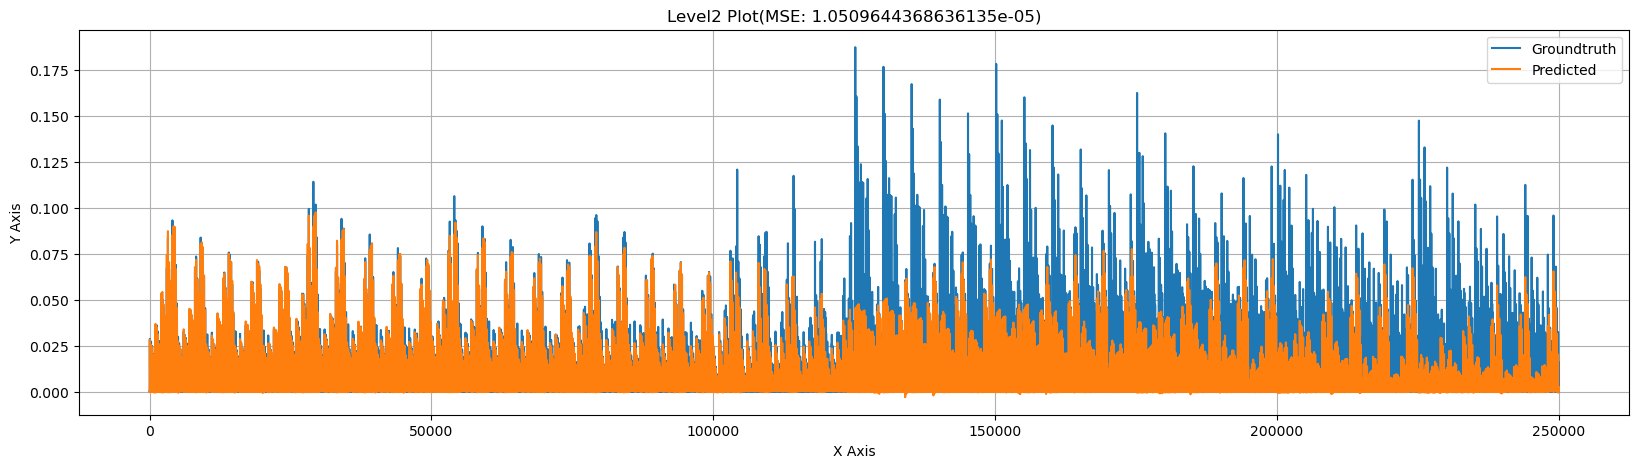

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,5))
# plt.plot(y_test_original[:], label='Groundtruth')
# plt.plot(y_pred_original[:], label='Predicted')
plt.plot(y, label='Groundtruth')
plt.plot(pre_ori, label='Predicted')
plt.title(f'Level2 Plot(MSE: {mse})')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
pre_ori

array([0.00019084, 0.00017517, 0.0001595 , ..., 0.00187326, 0.00208097,
       0.002629  ], dtype=float32)

In [ ]:
# for MLP_19, MLP_32
# X_train = df.drop(['Hosp No','target'], axis=1)
# Y_train = df[['target']]
# X_validation = df_val.drop(['Hosp No','target'], axis=1)
# Y_validation = df_val[['target']]

Scaler1 = StandardScaler()
Scaler2 = StandardScaler()

x_train = pd.DataFrame(Scaler1.fit_transform(X_train)).values
y_train  = pd.DataFrame((Y_train)).values

x_validation = pd.DataFrame(Scaler2.fit_transform(X_validation)).values
y_validation  = pd.DataFrame((Y_validation)).values

seed = 1988

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

class MLP_5(nn.Module):
    def __init__(self):
        super(MLP_5, self).__init__()
        self.fc1 = nn.Linear(5, 4)
        self.fc2 = nn.Linear(4, 3)
        self.fc3 = nn.Linear(3, 2)
        self.fc4 = nn.Linear(2, 1)
        self.activate = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        # x = self.nn.Sigmoid(x)
        x = self.activate(x)
        return x

class MLP_19(nn.Module):
    def __init__(self):
        super(MLP_19, self).__init__()
        self.fc1 = nn.Linear(19, 16)
        self.fc2 = nn.Linear(16, 14)
        self.fc3 = nn.Linear(14, 10)
        self.fc4 = nn.Linear(10, 6)
        self.fc5 = nn.Linear(6, 3)
        self.fc6 = nn.Linear(3, 1)
        self.activate = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        
        x = self.activate(x)
        return x    

class MLP_36(nn.Module):
    def __init__(self):
        super(MLP_36, self).__init__()
        self.fc1 = nn.Linear(19, 36)
        self.fc2 = nn.Linear(36, 72)
        self.fc3 = nn.Linear(72, 144)
        self.fc4 = nn.Linear(144, 72)
        self.fc5 = nn.Linear(72, 36)
        self.fc6 = nn.Linear(36, 1)
        self.activate = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        
        x = self.activate(x)
        return x    

# model = MLP_5()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
# model = MLP_19()
# model = MLP_36()
# print(model)


# criterion = nn.BinaryCrossEntropyWithLogits()
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
# torch.nn.functional.binary_cross_entropy


kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
torch.manual_seed(seed)

# from sklearn.neural_network import MLPClassifier
minimum_epoch = 2000
n_epochs = 10000
beta = 0.4


# print("Model info. ", model)


for fold_n, (train_idx, val_idx) in enumerate(kfold.split(X_train)):

    # Initial setting
    print("")
    print(f"Training fold number: {fold_n}")
    train_loss = 0
    train_loss_min = np.Inf

    validation_loss = 0
    validation_loss_min = np.Inf

    train_acc_max = 0
    train_precision_max = 0
    train_recall_max = 0
    train_f1_max = 0
    train_rocauc_max = 0

    best_epoch = 0
    validation_acc_best = 0
    validation_precision_best = 0
    validation_recall_best = 0
    validation_f1_best = 0
    validation_rocauc_best = 0

    model = MLP_5()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


    for epoch in range(n_epochs):
        train_features = X_train.iloc[train_idx]
        train_target = Y_train.iloc[train_idx]
        val_features = X_train.iloc[val_idx]
        val_target = Y_train.iloc[val_idx]
        
        train_features = Variable(torch.FloatTensor(pd.DataFrame(Scaler1.fit_transform(train_features)).values))
        train_target = Variable(torch.FloatTensor(pd.DataFrame((train_target)).values))
        val_features = Variable(torch.FloatTensor(pd.DataFrame(Scaler1.fit_transform(val_features)).values))
        val_target = Variable(torch.FloatTensor(pd.DataFrame((val_target)).values))


        # Training

        optimizer.zero_grad()
        output = model(train_features)
        loss = criterion(output,train_target)
        loss.backward()
        optimizer.step()

        # beta = torch.mean(output)
        # values, labels = torch.max(output, 1)
        output[output>=beta] = 1
        output[output<beta] = 0
        
        # output_A = np.squeeze(train_target)
        output_A = train_target.data.numpy()
        output_B = output.data.numpy()

        train_loss = loss.item()

        train_acc = accuracy_score(output_A, output_B)
        train_precision = precision_score(output_A, output_B, zero_division=0)
        train_recall = recall_score(output_A, output_B, zero_division=0)
        train_f1 = f1_score(output_A, output_B, zero_division=0)
        train_rocauc = roc_auc_score(output_A, output_B)


        # Validation

        with torch.no_grad():
            output_val = model(val_features)
        loss_val = criterion(output_val, val_target)

        # output_origin = output_val

        output_val[output_val>=beta] = 1
        output_val[output_val<beta] = 0

        output_val_A = val_target.data.numpy()
        output_val_B = output_val.data.numpy()

        validation_loss = loss_val.item()

        validation_acc = accuracy_score(output_val_A, output_val_B)
        validation_precision = precision_score(output_val_A, output_val_B, zero_division=0)
        validation_recall = recall_score(output_val_A, output_val_B, zero_division=0)
        validation_f1 = f1_score(output_val_A, output_val_B, zero_division=0)
        validation_rocauc = roc_auc_score(output_val_A, output_val_B)

        # validation_roc_curve = roc_curve(output_val_A, output_origin)


        # Scoring
        
        if train_loss <= train_loss_min:
            print("||Epoch: {:5}|| Train loss decreased ({:6f} ===> {:6f}). No saving the model...".format(epoch+1,train_loss_min,train_loss))
            train_loss_min = train_loss
            train_acc_max = train_acc
            train_precision_max = train_precision
            train_recall_max = train_recall
            train_f1_max = train_f1
            train_rocauc_max = train_rocauc
        
        if minimum_epoch <= epoch:

            if validation_loss <= validation_loss_min: # if validation_loss <= validation_loss_min: # if validation_f1_best < validation_f1:

                best_epoch = epoch+1

                validation_loss_min = validation_loss
                validation_acc_best = validation_acc
                validation_precision_best = validation_precision
                validation_recall_best = validation_recall
                validation_f1_best = validation_f1
                validation_rocauc_best = validation_rocauc

                with torch.no_grad():
                    output_v = model(val_features)

                # validation_roc_curve_best = validation_roc_curve

            if epoch % 500 == 0:
                # print(f"======== FOLD: {fold_n} ========")
                # print(np.unique(validation_roc_curve))
                print(f"Fold: {fold_n}, Epoch: {epoch+1}, Train Loss: {train_loss}, Passing rate: {train_acc}, Precision: {train_precision}, Recall: {train_recall}, F1-Score: {train_f1}, roc-auc: {train_rocauc}")
                print(f"Epoch: {epoch+1}, Validation Loss: {validation_loss}, Passing rate: {validation_acc}, Precision: {validation_precision}, Recall: {validation_recall}, F1-Score: {validation_f1}, roc-auc: {validation_rocauc}")

    print("")
    print("")
    print(f'Fold {fold_n}, Training Ended!!')
    print(f'||Final score(train)|| Loss: {train_loss_min}, Accuracy(Passing rate): {train_acc_max}, Precision: {train_precision_max}, Recall: {train_recall_max}, F1-Score: {train_f1_max}, roc-auc: {train_rocauc_max}')
    print(f'||Final score(validation)|| Best epoch: {best_epoch}, Loss: {validation_loss_min}, Accuracy(Passing rate): {validation_acc_best}, Precision: {validation_precision_best}, Recall: {validation_recall_best}, F1-Score: {validation_f1_best}, roc-auc: {validation_rocauc_best}')
    # print(validation_roc_curve_best)
    # with torch.no_grad():
    #     output_v = model(val_features)

    print(roc_curve(val_target, output_v))

